In [31]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
# Alternative plotting backend for interative data exploration
# %matplotlib notebook
from numpy import log, exp
import os
import pandas as pd

# choose font - can be deactivated
from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Inconsolata']

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# suppress warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
LW = 3   # line width

import ipywidgets as widgets
from IPython.display import HTML

In [66]:
pd.__version__

'0.25.3'

In [32]:
EXPLANATION = """\
<div class="app-sidebar">
<p><em>Coronavirus Numbers per Country.</em><p>

<p>Select which country to plot the coronavirus numbers for.</p>

<p>Code used from  <a href="https://github.com/fangohr/coronavirus-2020/blob/master/index.ipynb">
Hans Fangohr's coronavirus-2020 repository</a>.</p>
</div>
"""

In [33]:
HTML("""\
<style>
.app-subtitle {
    font-size: 1.5em;
}

.app-subtitle a {
    color: #106ba3;
}

.app-subtitle a:hover {
    text-decoration: underline;
}

.app-sidebar p {
    margin-bottom: 1em;
    line-height: 1.7;
}

.app-sidebar a {
    color: #106ba3;
}

.app-sidebar a:hover {
    text-decoration: underline;
}
</style>
""")

In [52]:
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def double_time_exponential(q2_div_q1, t2_minus_t1=None):
    """ See https://en.wikipedia.org/wiki/Doubling_time"""
    if t2_minus_t1 is None:
        t2_minus_t1 = np.ones(q2_div_q1.shape)
    return t2_minus_t1 * np.log(2) / np.log(q2_div_q1) 
    
def fetch_deaths():
    url = os.path.join(base_url, "time_series_covid19_" + "deaths" + "_global.csv")
    df = pd.read_csv(url, index_col=1)
    return df

def fetch_cases():
    url = os.path.join(base_url, "time_series_covid19_" + "confirmed" + "_global.csv")
    df = pd.read_csv(url, index_col=1)
    return df

In [39]:
def plot_time_step(ax, series, style="-", logscale=True):
    ax.step(series.index, series.values, style, label=series.country + " " + series.label,
           linewidth=LW)
    if logscale:
        ax.set_yscale('log')
    ax.legend()
    ax.set_ylabel("total numbers")
    return ax

def plot_change_bar(ax, series, color, rolling=None):
    change = series.diff().dropna()   # lose one point at beginning

    if rolling:
        rolling_label = f" {rolling}-day rolling mean"
        rolling_series = change.rolling(rolling, center=True).mean()
        bar_alpha = 0.2
    else:
        rolling_label = ""
        bar_alpha = 1.0

    label = series.country + " new " + series.label 
    ax.bar(change.index, change.values, color=color, label=label, alpha=bar_alpha, 
           linewidth=LW)
    if rolling:
        ax.plot(rolling_series.index, rolling_series.values, color=color, label=label + rolling_label,
                linewidth=LW)
    ax.legend()
    ax.set_ylabel('daily change')
    return ax

def plot_doubling_time(ax, series, color, minchange=10):
    # only keep values where there is a change of a minumum number
    sel = series.diff() <= minchange
    series.drop(series[sel].index, inplace=True)
    
    # we assume we have one value for every day - should check XXX
    q2_div_q1 = series.pct_change() + 1  # computes q2/q1
    q2_div_q1.replace(np.inf, np.nan, inplace=True)  # get rid of x/0 results
    q2_div_q1.dropna(inplace=True)
    dtime = double_time_exponential(q2_div_q1, t2_minus_t1=1)
    dtime.dropna(inplace=True)
    label = series.country + " new " + series.label 
    ax.plot(dtime.index, dtime.values, 'o', color=color, alpha=0.3, label=label)
    
    # need rolling average to smooth out weekly variations
    rolling = dtime.rolling(7, center=True).mean()
        
    # good to take maximum value from here
    ymax = min(rolling.max()*1.5, 500)
    if np.isnan(ymax):
        # This happens is rolling is empty, for example for deaths in Austria, Singapore
        print(f"Can't plot doublingtime line for {series.label} in {series.country} due to too small numbers")
        ymax = 10
        
    # some countries require special care
    if series.country == 'China':
            ymax = 100        
        
    ax.set_ylim(0, ymax)
    ax.plot(dtime.index, rolling, "-", color=color, alpha=1.0, label=label + ' 7-day rolling mean',
            linewidth=LW)
    ax.legend()
    ax.set_ylabel("doubling time [days]")
    return ax, rolling, dtime

In [61]:
class App:
    
    def __init__(self):
        self._deaths = fetch_deaths()
        self._cases = fetch_cases()
        available_countries = self._cases.index.values
        self._country_dropdown = self._create_dropdown(available_countries, np.argwhere(available_countries =="Germany")[0][0])
        self._plot_container = widgets.Output()
        _app_container = widgets.VBox([
            widgets.HBox([self._country_dropdown]),
            self._plot_container
        ], layout=widgets.Layout(align_items='center', flex='2 0 auto'))
        self.container = widgets.VBox([
            widgets.HTML(
                (
                    '<h1>Coronavirus Country Status</h1>'
                    # '<h2 class="app-subtitle"><a href="https://github.com/pbugnion/voila-gallery/blob/master/country-indicators/index.ipynb">Link to code</a></h2>'
                ), 
                layout=widgets.Layout(margin='0 0 5em 0')
            ),
            widgets.HBox([
                _app_container, 
                widgets.HTML(EXPLANATION, layout=widgets.Layout(margin='0 0 0 2em'))
            ])
        ], layout=widgets.Layout(flex='1 1 auto', margin='0 auto 0 auto', max_width='1024px'))
        self._update_app()

    def _create_dropdown(self, indicators, initial_index):
        dropdown = widgets.Dropdown(options=indicators, value=indicators[initial_index])
        dropdown.observe(self._on_change, names=['value'])
        return dropdown

    def _create_plot(self, country):
        self._overview(country)

    def _on_change(self, _):
        self._update_app()

    def _get_country(self, country):
        """Given a country name, return deaths and cases as time series.
        All rows should contain a datetime index and a value"""
        assert country in self._deaths.index, f"{country} not in available countries. These are {sorted(self._deaths.index)}"

        # Some countries report sub areas (i.e. multiple rows per country):
        if country in ["China", "France", "United Kingdom"]:
            d = self._deaths.loc[country].sum()
            c = self._cases.loc[country].sum()
        else:
            d = self._deaths.loc[country]
            c = self._cases.loc[country]

        # make date string into timeindex
        d.index = pd.to_datetime(d.index, errors="coerce", format="%m/%d/%y")
        c.index = pd.to_datetime(c.index, errors="coerce", format="%m/%d/%y")
        # drop all rows that don't have data
        # sanity check: how many do we drop?
        if c.index.isnull().sum() > 3:
            print(f"about to drop {c.index.isnull().sum()} entries due to NaT in index", c)
        c = c[c.index.notnull()] 

        if d.index.isnull().sum() > 3:
            print(f"about to drop {d.index.isnull().sum()} entries due to NaT in index", d)
        d = d[d.index.notnull()] 

        # check there are no NaN is in the data
        assert c.isnull().sum() == 0, f"{c.isnull().sum()} NaNs in {c}"
        assert d.isnull().sum() == 0, f"{d.isnull().sum()} NaNs in {d}"

        # label data
        c.country = country
        c.label = "cases"

        d.country = country
        d.label = "deaths"

        return c, d
    
    def _overview(self, country):
        c, d = self._get_country(country)

        fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=False)
        ax = axes[0]
        plot_time_step(ax=ax, series=c, style="-C1")
        plot_time_step(ax=ax, series=d, style="-C0")

        ax = axes[1]
        plot_change_bar(ax=ax, series=c, rolling=7, color="C1")
        if country == "China":
            ax.set_ylim(0, 5000)

        ax = axes[2]
        plot_change_bar(ax=ax, series=d, rolling=7, color="C0")

        ax = axes[3]
        plot_doubling_time(ax, series=d, color="C0")
        plot_doubling_time(ax, series=c, color="C1")

        # enforce same x-axis on all plots
        axes[1].set_xlim(axes[0].get_xlim())
        axes[2].set_xlim(axes[0].get_xlim())
        axes[3].set_xlim(axes[0].get_xlim())


        fig.tight_layout(pad=1)

        title = f"Overview {c.country}, last data point from {c.index[-1].date().isoformat()}"
        axes[0].set_title(title, )

        filename = os.path.join("figures", c.country.replace(" ", "-").replace(",", "-") + '.svg')
        fig.savefig(filename)

        return axes, c, d


    def _update_app(self):
        country = self._country_dropdown.value
        self._plot_container.clear_output(wait=True)
        with self._plot_container:
            self._create_plot(country)
            plt.show()

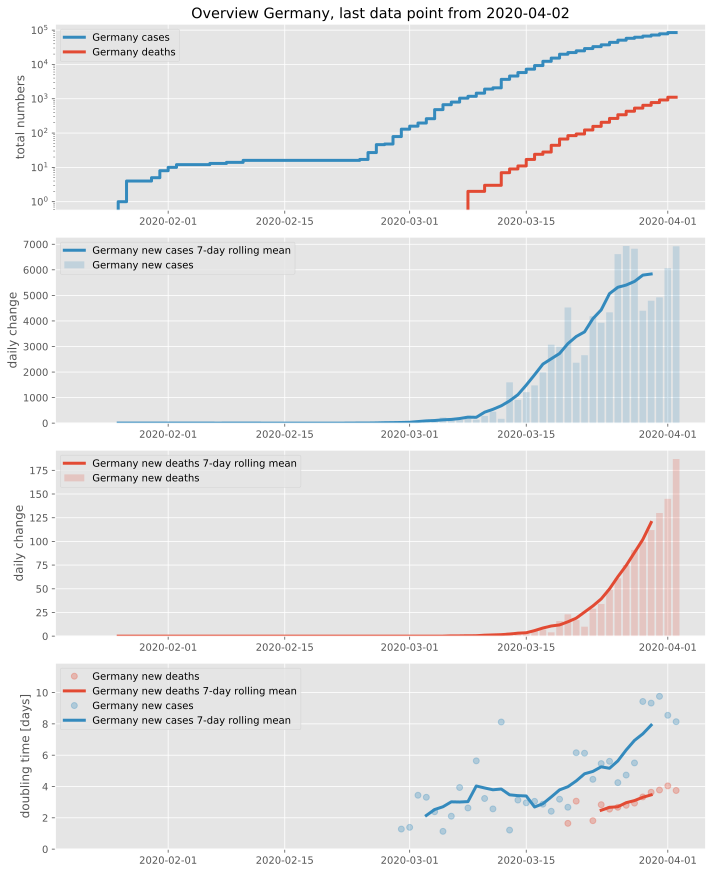

In [62]:
app = App()

app.container